# 第03章: モデル評価指標

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] 分類指標（正解率、精度、再現率、F1）を理解できる
- [ ] 回帰指標（RMSE、R²、MAE）を理解できる
- [ ] 混同行列を読み取れる
- [ ] ROC曲線とAUCを理解できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Python基礎
- ✅ NumPy基礎
- ✅ 前処理 ← Notebook 02

⏱️ **推定学習時間**: 60-75分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: 評価

---


## 📖 モデル評価指標：正しい測定なくして改善なし

「測定できないものは改善できない」という経営学の格言があります。
機械学習でも、モデルの性能を正しく測定することが成功の鍵となります。

### なぜ複数の評価指標が必要なのか？

「正解率が95%なら良いモデル」と思うかもしれませんが、必ずしもそうではありません。

**例：がん検診**
- データ: 1000人中10人ががん患者（1%）
- モデル: 全員に「健康」と予測
- 正解率: 99%！

しかし、このモデルはがん患者を一人も見つけられません。
正解率だけでは不十分なことが分かります。

### 医療診断のたとえ

医療診断では、以下の2つのエラーがあります：
- **偽陽性（False Positive）**: 健康な人をがんと診断（不必要な心配）
- **偽陰性（False Negative）**: がん患者を健康と診断（見逃し、命に関わる）

どちらのエラーがより深刻かは、状況によって異なります。
機械学習でも同じく、問題に応じて重視する指標を選ぶ必要があります。

### このノートブックで学ぶこと

- **混同行列（Confusion Matrix）**: 予測結果の詳細な内訳
- **適合率（Precision）**: 陽性と予測したもののうち、実際に陽性の割合
- **再現率（Recall）**: 実際の陽性のうち、正しく陽性と予測できた割合
- **F1スコア**: 適合率と再現率のバランス
- **ROC曲線とAUC**: モデルの総合的な性能評価

それでは、実際のデータを使って各指標を理解していきましょう！


In [1]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import (
    train_test_split, cross_val_score, learning_curve, validation_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    # Regression metrics
    mean_squared_error, mean_absolute_error, r2_score,
    # Classification metrics
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, precision_recall_curve, auc
)

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## Part 1: Regression Metrics

In [2]:
# Generate regression data
X, y = make_regression(n_samples=500, n_features=10, noise=20, random_state=42)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

print(f"Training samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")

Training samples: 400
Test samples: 100


/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



  MLPRegressor（多層パーセプトロン回帰）

  このコードは、人間の脳の神経回路網を模した「ニューラルネットワーク」を使って、数
  値を予測するモデル（回帰モデル）を作成・学習させています。

  正式名称は Multi-Layer Perceptron（多層パーセプトロン）です。

  1. どんなモデルなのか？
  線形回帰のように直線を引くのではなく、データの中にある複雑で非線形なパターン（ぐ
  にゃぐにゃした境界線や関係性）を学習できる強力なモデルです。

   * 入力層: 特徴量を受け取る入り口。
   * 隠れ層（中間層）:
     情報を受け取り、計算・変換を行う「処理部」。ここが何層もあると「ディープラーニ
     ング」と呼ばれます。
   * 出力層: 最終的な予測値（数値）を出す出口。

  2. パラメータの解釈 (hidden_layer_sizes=(50, 25))
  ここがこのモデルの「脳の構造」を決める最も重要な部分です。

   * `(50, 25)` の意味:
       * 第1隠れ層:
         50個のニューロン（ノード）があります。入力データを50通りの視点で分析します
         。
       * 第2隠れ層:
         25個のニューロンがあります。第1層からの情報をさらに要約・抽出して25個の情
         報に圧縮します。
       * この2段階の処理を経て、最終的な答えを出します。
   * イメージ:
      
  50人の担当者がデータを細かく分析し、その報告書を25人の課長がさらにまとめて、最後
  に部長（出力層）が結論を出す、といった組織構造のようなものです。
      
  層を深くしたり（数を増やす）、幅を広くする（数値を大きくする）ことで、より複雑な
  問題を解けるようになりますが、計算時間も増えます。

  3. その他の設定
   * `max_iter=500`:
       * 学習の回数（エポック数）です。「問題集を最大500周して勉強しなさい」という
         命令です。
       * 難しすぎる問題だと、500回やっても収束しない（勉強しきれない）場合があり、
         その時は警告（ConvergenceWarning）が出ます。
   * `random_state=42`:
       * ニューラルネットワークは、最初に重みを「ランダム」に決めます。この初期状態
         を固定して、毎回同じ結果が出るようにしています。

  4. fit で何が起きているか？
  model.fit(X_train_scaled, y_train)
  を実行すると、「誤差逆伝播法（バックプロパゲーション）」というアルゴリズムが動き
  ます。

   1. データを入力して、予測値を出す。
   2. 正解（y_train）とのズレ（誤差）を計算する。
   3. その誤差を小さくするように、ネットワーク内の全ての結合の強さ（重み）を少しず
      つ修正する。
   4. これを最大500回繰り返す。

  重要な注意点：スケーリング
  コード内で X_train ではなく X_train_scaled が使われていることに注目してください。

  ニューラルネットワークは、データのスケール（単位）に非常に敏感です。
  例えば「身長（170cm）」と「視力（1.0）」のように桁が違うデータが混ざっていると、
  数値の大きい方に引きずられて学習がうまくいきません。
  そのため、MLPを使う前には必ず `StandardScaler` や `MinMaxScaler`
  などでデータを正規化・標準化する必要があります。

In [3]:
# ============================================================
# [コードの説明]
# ============================================================

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Regression Metrics:")
print("="*50)
print(f"Mean Squared Error (MSE):     {mse:.4f}")
print(f"Root Mean Squared Error:      {rmse:.4f}")
print(f"Mean Absolute Error (MAE):    {mae:.4f}")
print(f"R² Score:                     {r2:.4f}")

Regression Metrics:
Mean Squared Error (MSE):     466.8377
Root Mean Squared Error:      21.6064
Mean Absolute Error (MAE):    17.6563
R² Score:                     0.9765


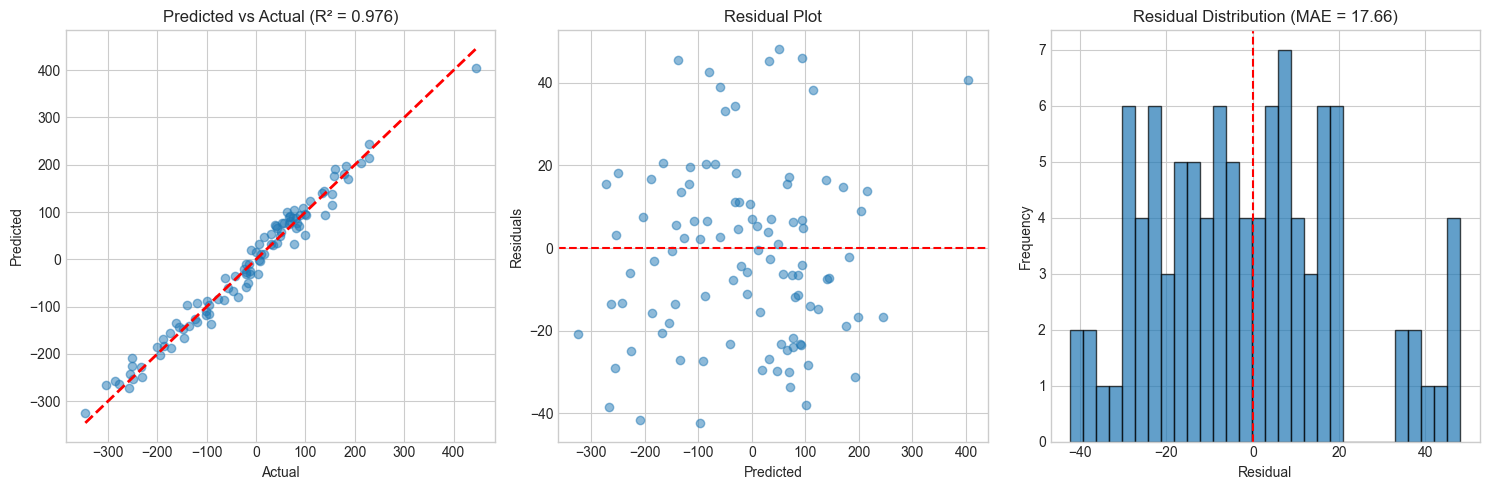

In [4]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Predicted vs Actual (R² = {r2:.3f})')

# Residual plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Residual distribution
axes[2].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='r', linestyle='--')
axes[2].set_xlabel('Residual')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Residual Distribution (MAE = {mae:.2f})')

plt.tight_layout()
plt.show()

### Metric Explanations

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| MSE | Σ(y - ŷ)² / n | Penalizes large errors more |
| RMSE | √MSE | Same units as target |
| MAE | Σ|y - ŷ| / n | Average absolute error |
| R² | 1 - SS_res/SS_tot | Variance explained (0-1) |

## Part 2: Classification Metrics

In [5]:
# Generate classification data
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=10,
    n_classes=2, weights=[0.7, 0.3],  # Imbalanced
    random_state=42
)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
clf = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

print(f"Class distribution in test set: {np.bincount(y_test)}")

Class distribution in test set: [139  61]


**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

  MLPClassifier（多層パーセプトロン分類器）

  このコードは、「多層パーセプトロン（MLP）」を使って、データがどのカテゴリ（クラス
  ）に属するかを予測するモデル（分類モデル）を作成・学習させています。

  MLPRegressor が連続的な数値を予測するのに対し、MLPClassifier
  は離散的なクラスラベル（例:
  「犬」か「猫」か、「迷惑メール」か「通常メール」か）を予測します。

  1. どんなモデルなのか？
  基本的な構造は MLPRegressor
  と同じで、人間の脳の神経回路網を模したニューラルネットワークです。

   * 複雑な非線形パターンを学習し、データ空間を複雑な境界線で分割してクラス分けがで
     きます。
   * 入力層、隠れ層、出力層から構成されます。

  2. MLPRegressor との主な違い

   1. 出力層の活性化関数:
       * MLPRegressor
         の出力層は、通常、活性化関数を持たないか、線形関数で、直接数値を吐き出しま
         す。
       * MLPClassifier
         の出力層は、通常、クラスの数に対応したニューロンを持ち、それぞれに「ソフト
         マックス関数 (softmax
         function)」のような活性化関数が適用されます。これにより、各クラスに属する
         確率が出力されます。
       * 例: 3クラス分類なら、出力は [0.1, 0.8, 0.1]
         のように、合計が1になる確率のセットになります。

   2. 最終的な予測:
       * 確率が出力された後、最も確率の高いクラスが最終的な予測結果となります（例:
         [0.1, 0.8, 0.1] なら2番目のクラスを予測）。

   3. 損失関数 (Loss Function):
       * MLPRegressor
         は予測値と正解値の「差の二乗」のような回帰問題に適した損失関数を使います。
       * MLPClassifier は、「クロスエントロピー誤差 (Cross-Entropy
         Loss)」のような、分類問題に適した損失関数を使って、予測された確率分布と実
         際のクラス分布のズレを最小化するように学習します。

  3. パラメータの解釈 (hidden_layer_sizes=(50, 25), max_iter=500, random_state=42)
  これらのパラメータの意味は MLPRegressor と全く同じです。

   * `hidden_layer_sizes=(50, 25)`:
     2つの隠れ層を持ち、それぞれ50個、25個のニューロンで構成されることを示します。
     これにより、モデルの表現能力（どれだけ複雑なパターンを学習できるか）が決まりま
     す。
   * `max_iter=500`:
     最大学習回数（エポック数）です。この回数だけデータの反復学習を行います。
   * `random_state=42`: ランダムな初期重みを固定し、実験の再現性を確保します。

  4. fit で何が起きているか？
  clf.fit(X_train_scaled, y_train) を実行すると、MLPRegressor
  と同様に「誤差逆伝播法」を用いて学習が進みます。モデルは、入力 X_train_scaled
  から、対応するクラス y_train
  を最も正確に予測できるように、ネットワーク内の結合の重みを繰り返し調整します。

  5. 重要な注意点：スケーリング
  MLPRegressor と同じく、MLPClassifier も特徴量のスケール（単位）に非常に敏感です。
  そのため、X_train_scaled
  のように事前にデータを正規化・標準化する処理が必須となります。この前処理を怠ると
  、学習が非常に不安定になったり、性能が著しく低下したりする可能性があります。

  まとめ

  MLPClassifier
  は、複雑なパターンを学習し、カテゴリデータ（クラス）を予測するための強力なツール
  です。適切なデータ前処理とハイパーパラメータの設定により、高い分類性能を発揮する
  ことが期待できます。

In [6]:
# ============================================================
# [コードの説明]
# ============================================================

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Classification Metrics:")
print("="*50)
print(f"Accuracy:     {accuracy:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"Recall:       {recall:.4f}")
print(f"F1 Score:     {f1:.4f}")
print(f"ROC-AUC:      {roc_auc:.4f}")

Classification Metrics:
Accuracy:     0.9200
Precision:    0.8814
Recall:       0.8525
F1 Score:     0.8667
ROC-AUC:      0.9743


**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

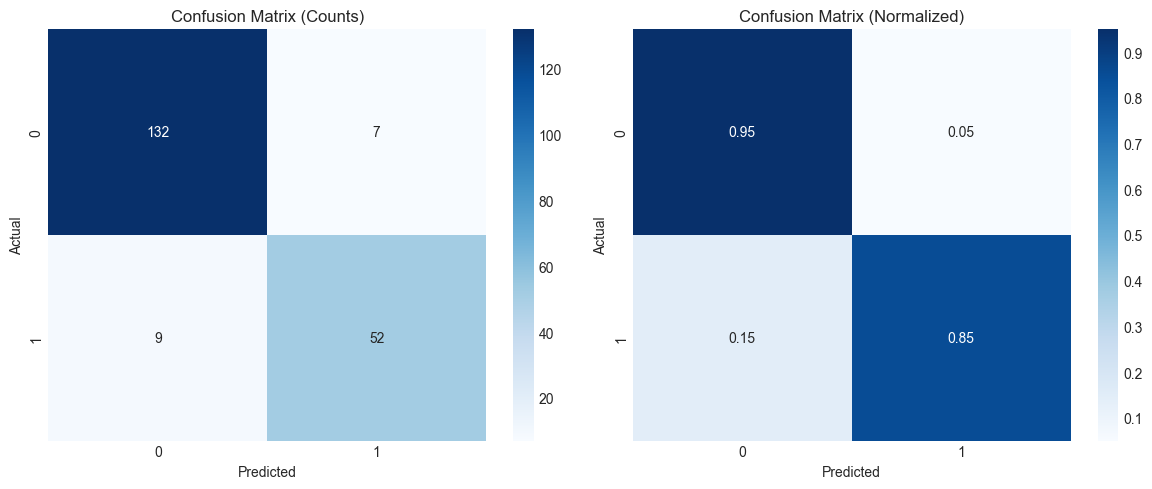


True Negatives: 132, False Positives: 7
False Negatives: 9, True Positives: 52


In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()

# Extract values
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn}, False Positives: {fp}")
print(f"False Negatives: {fn}, True Positives: {tp}")

**混同行列の読み方**：
- 対角線上の値が大きいほど良い（正しい予測）
- 対角線外の値は誤予測
- どのクラスの誤予測が多いか分析できる

混同行列から、モデルの強みと弱みが見えてきます。
特定のクラスの予測精度が低い場合、そのクラスのサンプルを
増やすなどの対策が考えられます。

### 🎯 混同行列（Confusion Matrix）を理解する

混同行列は、モデルの予測結果を詳細に分析するための基本的なツールです。

#### 混同行列の構造

2クラス分類の場合、混同行列は以下のような2×2の表になります：

```
                予測: 陰性    予測: 陽性
実際: 陰性      TN           FP
実際: 陽性      FN           TP
```

**各要素の意味**：

**TN (True Negative)**: 真陰性
- 実際に陰性で、陰性と予測した（正解）
- 例：健康な人を健康と診断

**FP (False Positive)**: 偽陽性（第1種の過誤）
- 実際は陰性なのに、陽性と予測した（誤り）
- 例：健康な人をがんと診断
- 別名：「狼少年のエラー」

**FN (False Negative)**: 偽陰性（第2種の過誤）
- 実際は陽性なのに、陰性と予測した（誤り）
- 例：がん患者を健康と診断
- 別名：「見逃しのエラー」

**TP (True Positive)**: 真陽性
- 実際に陽性で、陽性と予測した（正解）
- 例：がん患者をがんと診断

#### 具体例で理解する

**スパムメールフィルター**

1000通のメールを分類した結果：

```
                 予測: 正常    予測: スパム
実際: 正常メール    850           50      (TN=850, FP=50)
実際: スパムメール   10           90      (FN=10, TP=90)
```

**この結果から分かること**：
- 正常メール900通のうち、850通を正しく分類（94.4%）
- しかし、50通の正常メールがスパムと誤判定（5.6%）← 重要なメールを見逃す
- スパムメール100通のうち、90通を正しく検出（90%）
- しかし、10通のスパムを見逃した（10%）

#### 正解率だけでは見えないもの

```
正解率 = (TN + TP) / 全体
       = (850 + 90) / 1000
       = 94%
```

94%という数字は良く見えますが、混同行列を見ると：
- 正常メールの5.6%がスパムと誤判定されている
- スパムの10%を見逃している

このように、混同行列は正解率だけでは分からない
モデルの詳細な性能を明らかにします。

#### ビジネスへの影響

**FPが多い場合（偽陽性）**：
- 重要なメールが spam フォルダに行く
- 顧客満足度の低下
- ビジネスチャンスの損失

**FNが多い場合（偽陰性）**：
- スパムメールが inbox に届く
- ユーザーの時間の浪費
- フィッシング詐欺のリスク

どちらのエラーを重視すべきかは、ビジネス要件によって異なります。


#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

In [8]:
# ============================================================
# [コードの説明]
# ============================================================

# Detailed classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.95      0.94       139
     Class 1       0.88      0.85      0.87        61

    accuracy                           0.92       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.92      0.92      0.92       200



### Metric Explanations

| Metric | Formula | Use When |
|--------|---------|----------|
| Accuracy | (TP+TN)/(TP+TN+FP+FN) | Balanced classes |
| Precision | TP/(TP+FP) | Cost of false positives high |
| Recall | TP/(TP+FN) | Cost of false negatives high |
| F1 | 2·(P·R)/(P+R) | Balance precision & recall |

## Part 3: ROC and Precision-Recall Curves

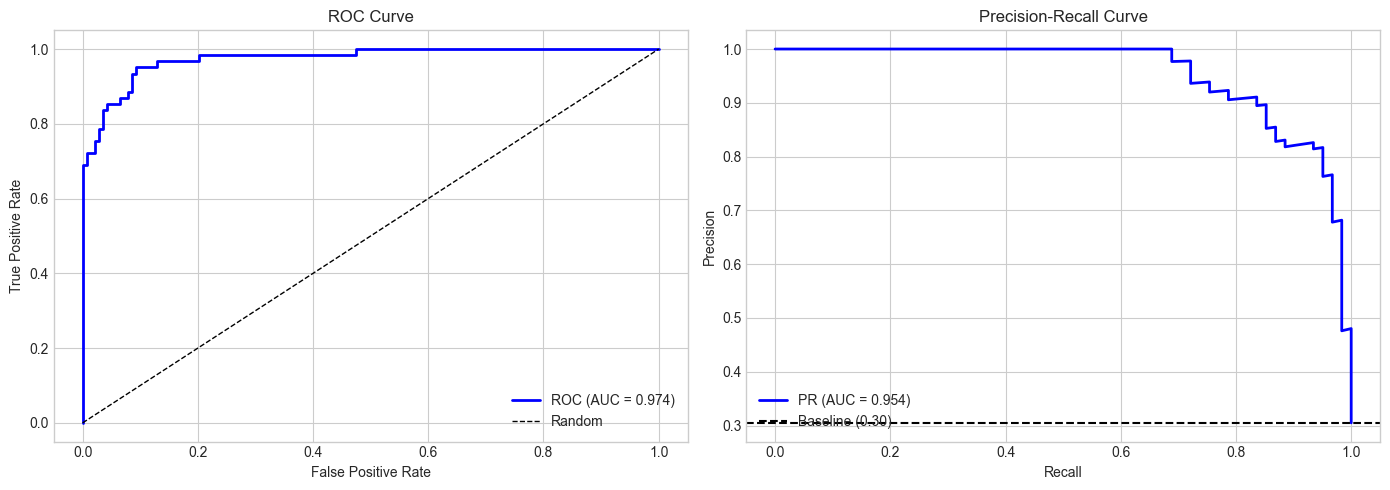

In [9]:
# Calculate curves
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_curve, precision_curve)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, 'b-', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# Precision-Recall Curve
axes[1].plot(recall_curve, precision_curve, 'b-', lw=2, label=f'PR (AUC = {pr_auc:.3f})')
baseline = np.sum(y_test) / len(y_test)
axes[1].axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.2f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc='lower left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### ⚖️ 適合率（Precision）と再現率（Recall）

適合率と再現率は、混同行列から計算される重要な指標です。

#### 適合率（Precision）：「予測の正確さ」

```
Precision = TP / (TP + FP)
```

「陽性と予測したもののうち、実際に陽性だった割合」

**質問**: 「このモデルが『陽性』と言ったら、どれくらい信頼できる？」

**例：スパムフィルター**
```
Precision = 90 / (90 + 50) = 90/140 = 64.3%
```

スパムと判定されたメールのうち、64.3%が本当にスパム。
つまり、35.7%は誤検出（正常メールがスパム扱い）。

#### 再現率（Recall）：「検出の網羅性」

```
Recall = TP / (TP + FN)
```

「実際の陽性のうち、正しく陽性と予測できた割合」

**質問**: 「実際の陽性を、どれだけ見つけられた？」

**例：スパムフィルター**
```
Recall = 90 / (90 + 10) = 90/100 = 90%
```

実際のスパムメールの90%を検出できた。
しかし、10%は見逃してしまった。

#### トレードオフの関係

適合率と再現率は、多くの場合トレードオフの関係にあります。

**例：スパムフィルターの閾値調整**

**厳しい判定（閾値を高く）**：
```
- より確実なものだけをスパムと判定
- 適合率: 高い（誤検出が少ない）
- 再現率: 低い（見逃しが多い）
```

**緩い判定（閾値を低く）**：
```
- 少しでも疑わしいものをスパムと判定
- 適合率: 低い（誤検出が多い）
- 再現率: 高い（見逃しが少ない）
```

#### どちらを重視すべきか？

**適合率を重視すべきケース**：

**1. 犯罪予測システム**
- FP（無実の人を容疑者扱い）は人権問題
- 慎重に、確実な証拠がある場合のみ陽性判定

**2. 高額商品の推薦システム**
- FP（興味のない商品を推薦）は顧客の不快感
- 確実に興味がありそうな商品のみ推薦

**3. 有料サービスの自動アップグレード**
- FP（不要なアップグレード）は顧客の不信感
- 本当に必要な人にのみ提案

**再現率を重視すべきケース**：

**1. がん検診**
- FN（がん患者の見逃し）は命に関わる
- 偽陽性（FP）は再検査で確認できる

**2. 不正取引検出**
- FN（不正の見逃し）は金銭的損失
- 誤検出（FP）は人間が最終確認

**3. 災害警報システム**
- FN（災害の見逃し）は人命に関わる
- 誤報（FP）は避難訓練と考える

#### 具体的な数値例

**医療診断（がん検診）**

ケース1: 適合率重視モデル
```
Precision = 95%  （陽性判定の95%が本当にがん）
Recall = 60%     （がん患者の60%しか検出できない）

問題: 40%のがん患者を見逃す → 危険！
```

ケース2: 再現率重視モデル
```
Precision = 20%  （陽性判定の80%は誤検出）
Recall = 98%     （がん患者の98%を検出）

問題: 多くの健康な人が精密検査を受ける → コスト増
       しかし、がんの見逃しは最小限 → 安全！
```

がん検診では、ケース2の方が適切です。
偽陽性は精密検査で確認できますが、
偽陰性（見逃し）は取り返しがつきません。

#### ビジネス上の意思決定

**コールセンターの顧客離反予測**

離反しそうな顧客を事前に検出し、リテンション施策を実施：

```
施策コスト: 1人あたり5,000円
顧客生涯価値: 1人あたり50,000円
```

**適合率重視（Precision = 80%, Recall = 40%）**：
```
予測: 100人が離反 → 80人が本当に離反、20人は誤検出
コスト: 100人 × 5,000円 = 50万円
効果: 80人 × 50,000円 = 400万円
利益: 350万円

ただし、実際の離反予定者200人のうち120人は見逃し
見逃した損失: 120人 × 50,000円 = 600万円
```

**再現率重視（Precision = 40%, Recall = 80%）**：
```
予測: 400人が離反 → 160人が本当に離反、240人は誤検出
コスト: 400人 × 5,000円 = 200万円
効果: 160人 × 50,000円 = 800万円
利益: 600万円

見逃した離反者: 40人
見逃した損失: 40人 × 50,000円 = 200万円
```

この場合、再現率重視の方が総合的な利益が大きくなります。


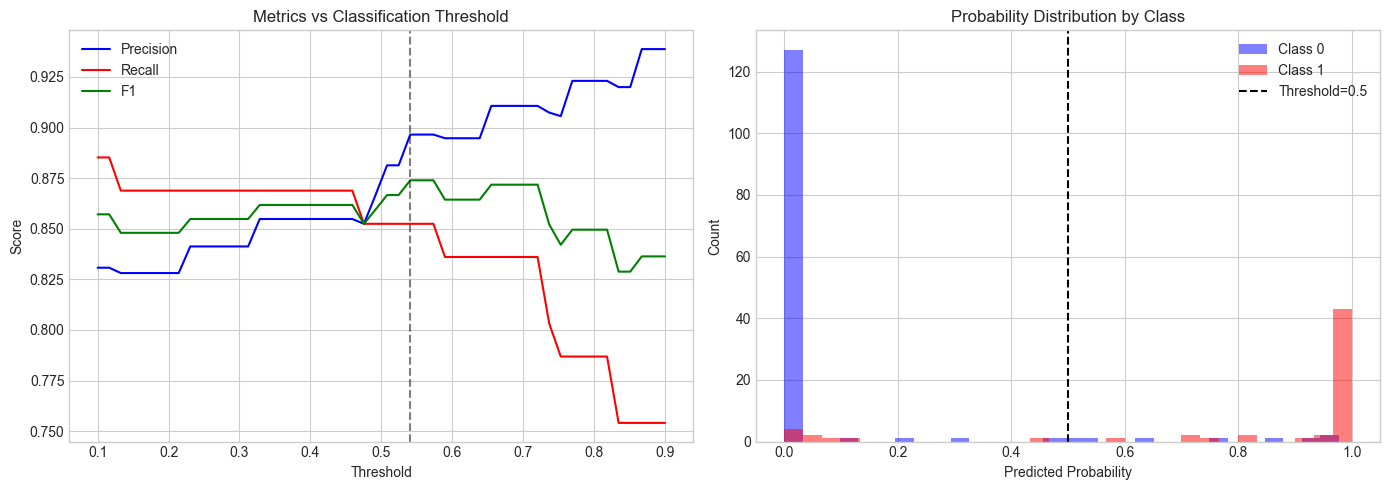

Optimal threshold (max F1): 0.54


In [10]:
# Threshold analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics vs threshold
thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_thresh, zero_division=0))

axes[0].plot(thresholds, precisions, 'b-', label='Precision')
axes[0].plot(thresholds, recalls, 'r-', label='Recall')
axes[0].plot(thresholds, f1s, 'g-', label='F1')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Metrics vs Classification Threshold')
axes[0].legend()
axes[0].grid(True)

# Find optimal threshold
optimal_idx = np.argmax(f1s)
optimal_threshold = thresholds[optimal_idx]
axes[0].axvline(x=optimal_threshold, color='k', linestyle='--', alpha=0.5)

# Probability distribution
axes[1].hist(y_prob[y_test == 0], bins=30, alpha=0.5, label='Class 0', color='blue')
axes[1].hist(y_prob[y_test == 1], bins=30, alpha=0.5, label='Class 1', color='red')
axes[1].axvline(x=0.5, color='k', linestyle='--', label='Threshold=0.5')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Count')
axes[1].set_title('Probability Distribution by Class')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Optimal threshold (max F1): {optimal_threshold:.2f}")

この図示（およびコード）の目的は、「AIが『YES（クラス1）』と判断する基準（しきい
  値）は、デフォルトの50%が本当に最適なのか？」
  を検証し、ベストな基準点を見つけることです。

  左と右、2つのグラフが何を語っているのか解説します。

  ---

  左のグラフ：Metrics vs Threshold（トレードオフの可視化）

  「合格ライン（しきい値）を変えると、成績はどう変わるか？」 を表しています。

   * 横軸 (Threshold):
       * 「確率何％以上なら YES（1）とみなすか」という基準です。
       * 左（0.1）に行くほど基準が緩く、右（0.9）に行くほど基準が厳しくなります。
   * 3本の線:
       * 🔴 Recall (再現率 - 赤):
           * 基準を厳しくする（右へ行く）ほど、下がります。
           * 「見逃し」が増えるからです。
       * 🔵 Precision (適合率 - 青):
           * 基準を厳しくする（右へ行く）ほど、基本的に上がります。
           * 自信満々のものしか選ばなくなるので、「誤報」が減るからです。
       * 🟢 F1 Score (バランス - 緑):
           * 赤と青の調和平均です。この山が一番高いところが、「見逃しも誤報も少ない
             、バランスの良い基準点」 です。
   * 黒い点線 (Optimal Threshold):
       * F1スコア（緑の線）が最大になる場所を示しています。このコードは「ここがこの
         モデルの最強の設定値ですよ」と教えてくれています。

  ---

  右のグラフ：Probability Distribution（モデルの自信の分布）

  「モデルはどれくらい自信を持って分類できているか？」 を表しています。

   * 横軸: モデルが出した「確率（0.0〜1.0）」。
   * 青い山 (Class 0):
     正解が「0」だったデータたちが、どれくらいの確率と予測されたか。
       * 理想: 0（左端）付近に山が固まっていてほしい。
   * 赤い山 (Class 1):
     正解が「1」だったデータたちが、どれくらいの確率と予測されたか。
       * 理想: 1（右端）付近に山が固まっていてほしい。
   * 真ん中の点線 (0.5):
       * 通常の判定ラインです。
   * 解釈のポイント:
       * 青い山と赤い山が左右にきっぱり分かれていれば優秀なモデルです。
       * もし真ん中で青と赤が重なっている部分があれば、そこは「モデルが迷っている（
         どっちつかずの確率を出している）領域」であり、誤判定が起きやすい場所です。

  ---

  なぜこの分析が必要なのか？（実務的な意味）

  通常、Scikit-learnの predict() は「確率50%以上なら
  1」と自動判定します。しかし、実務では50%が正解とは限りません。

   * がん検診AIの場合:
       * 見逃し（がんを見逃す）は絶対に許されません。
       * だから、しきい値を低く（例:
         0.2）設定して、怪しいものはとりあえず全部「要検査」にします（Recall優先）
         。
   * スパムメールフィルタの場合:
       * 誤報（大事なメールをゴミ箱に入れる）は絶対に避けたいです。
       * だから、しきい値を高く（例:
         0.9）設定して、確実にスパムだと言えるものだけ弾きます（Precision優先）。

  このコードは、その「ビジネス的な正解（最適なバランス）」を決定するための判断材料
  を提供しています。

## Part 4: Multi-class Classification Metrics

In [11]:
# Generate multi-class data
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=10,
    n_classes=4, n_clusters_per_class=1,
    random_state=42
)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
clf_multi = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
clf_multi.fit(X_train_scaled, y_train)

# Predictions
y_pred_multi = clf_multi.predict(X_test_scaled)

print(f"Number of classes: {len(np.unique(y))}")
print(f"Test set distribution: {np.bincount(y_test)}")

Number of classes: 4
Test set distribution: [50 50 50 50]


Scikit-learnの設計は非常に賢くできており、ユーザーがいちいち「これは4クラス分類だ
  よ」と宣言しなくても済むようになっています。

  具体的に、fit の内部で何が行われているか解説します。

  1. __init__ の時点（モデル作成時）

   1 clf_multi = MLPClassifier(hidden_layer_sizes=(100, 50), ...)
  この時点では、モデルは「まだ形が決まっていない」状態です。
   * 入力層: 何個入ってくるか知らない（Xを見てないから）。
   * 隠れ層: 100個 → 50個 という構成だけ知っている。
   * 出力層: 何個出せばいいか知らない（yを見てないから）。

  2. fit(X, y) の時点（学習開始時）
  ここで初めてデータが渡され、モデルの形が確定します。

   1. 入力層の決定:
      X_train の列数を見ます（今回は20列）。これで入力層のニューロンが 20個
  に決定されます。
   2. 出力層の決定:
      y_train の中にあるユニークな値（種類の数）を数えます。
      Scikit-learnは内部で np.unique(y_train) のような処理を行い、[0, 1, 2, 3]
  という4種類の値があることを発見します。
      これで出力層のニューロンが 4個 に決定されます。

  3. 自動的なモード切替
  さらに、クラスの数に応じて、モデルの挙動（活性化関数）も自動で切り替わります。

   * 2クラスの場合（0, 1）:
       * 出力ニューロン: 1個
       * 活性化関数: ロジスティック関数 (Sigmoid)
       * 意味: 「1である確率」だけを出力。

   * 3クラス以上の場合（今回）:
       * 出力ニューロン: クラス数分（4個）
       * 活性化関数: ソフトマックス関数 (Softmax)
       * 意味: [0.1, 0.7, 0.1, 0.1] のように、合計が100%になる確率分布を出力。

  確認方法
  学習が終わった後、以下の属性を見ると、モデルが自動認識したクラスを確認できます。

   1 print(clf_multi.classes_)
   2 # 出力: [0 1 2 3]
   3 
   4 print(clf_multi.n_outputs_)
   5 # 出力: 4

  このように、Scikit-learnはデータに合わせて柔軟に構造を変えてくれるため、コードを
  書く人間は楽ができる仕組みになっています。

In [12]:
# ============================================================
# [コードの説明]
# ============================================================

# Multi-class metrics
print("Multi-class Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred_multi))

# Different averaging methods
print("\nF1 Scores with different averaging:")
for avg in ['micro', 'macro', 'weighted']:
    f1_avg = f1_score(y_test, y_pred_multi, average=avg)
    print(f"  {avg:8s}: {f1_avg:.4f}")

Multi-class Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        50
           1       0.83      0.90      0.87        50
           2       0.98      0.94      0.96        50
           3       0.80      0.82      0.81        50

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200


F1 Scores with different averaging:
  micro   : 0.9000
  macro   : 0.9014
  weighted: 0.9014


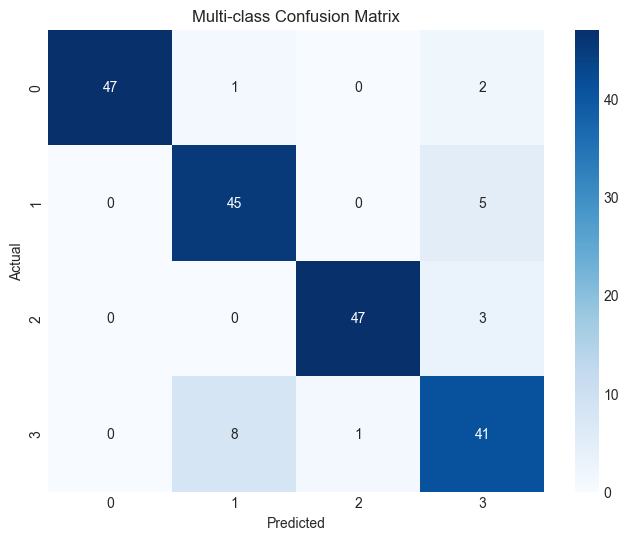

In [13]:
# ============================================================
# [コードの説明]
# ============================================================

# Multi-class confusion matrix
cm_multi = confusion_matrix(y_test, y_pred_multi)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multi-class Confusion Matrix')
plt.show()

## Part 5: Cross-Validation

In [14]:
# ============================================================
# [コードの説明]
# ============================================================

# Generate data
X, y = make_classification(n_samples=500, n_features=20, n_informative=10,
                          n_classes=2, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation with different metrics
clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results = {}

for metric in metrics:
    scores = cross_val_score(clf, X_scaled, y, cv=5, scoring=metric)
    results[metric] = scores
    print(f"{metric:12s}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

accuracy    : 0.9020 (+/- 0.0824)


/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

precision   : 0.9082 (+/- 0.1038)


/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

recall      : 0.8960 (+/- 0.0688)


/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

f1          : 0.9018 (+/- 0.0813)


/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


roc_auc     : 0.9634 (+/- 0.0459)


/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

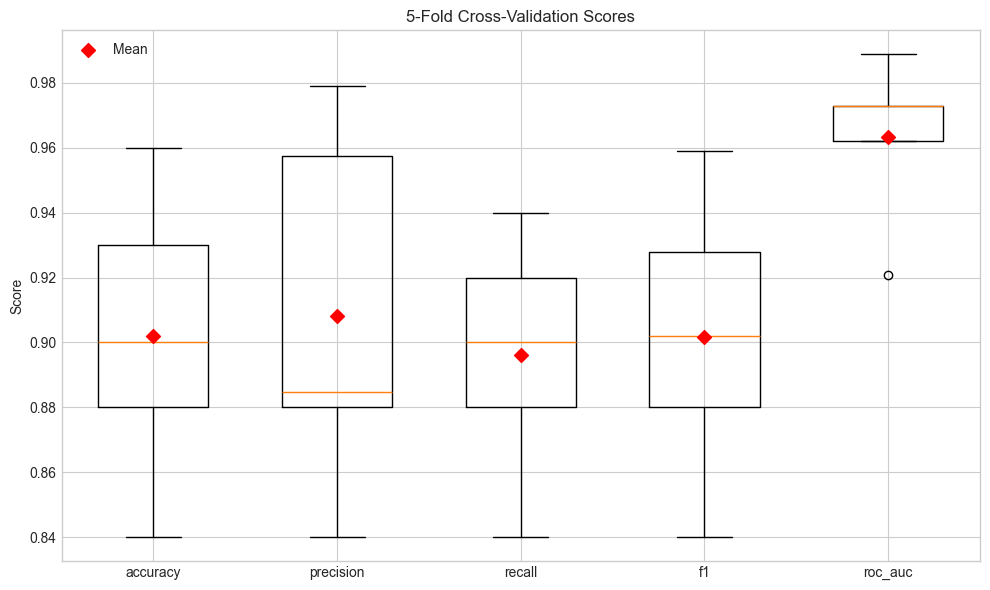

In [15]:
# ============================================================
# [コードの説明]
# ============================================================

# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 6))

positions = np.arange(len(metrics))
bp = ax.boxplot([results[m] for m in metrics], positions=positions, widths=0.6)

ax.set_xticks(positions)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('5-Fold Cross-Validation Scores')

# Add mean markers
means = [results[m].mean() for m in metrics]
ax.scatter(positions, means, marker='D', color='red', s=50, zorder=3, label='Mean')
ax.legend()

plt.tight_layout()
plt.show()

## Part 6: Learning Curves

/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

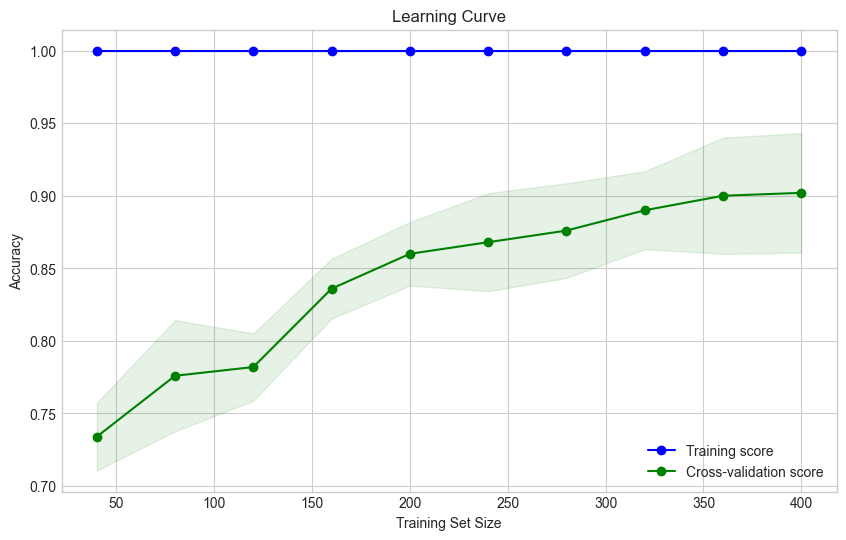

Interpretation:
- High training, low CV → Overfitting (need more data or regularization)
- Both low → Underfitting (need more complex model)
- Both converging high → Good fit


In [ ]:
# Generate learning curve
clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    clf, X_scaled, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

"""learning_curve
  関数は、機械学習モデルの診断において非常に強力ですが、内部で「具体的にどうデータ
  を分割して、何回学習しているのか」が少しイメージしづらい部分があります。

  詳しく解剖してみましょう。

  ---

  learning_curve の内部動作フロー

  この関数を呼び出すと、内部で「二重のループ」が回ります。

   1 train_sizes, train_scores, test_scores = learning_curve(
   2     clf, X, y,
   3     train_sizes=np.linspace(0.1, 1.0, 10),  # [10%, 20%, ..., 100%] の10段階
   4     cv=5,                                   # 5分割交差検証
   5     ...
   6 )

  この設定の場合、合計で 50回 (10段階 × 5分割) の学習と評価が行われます。

  外側のループ：データ量の段階 (train_sizes)
  まず、学習に使うデータ量の制限を変えていきます。
  例えば、全データが 1000個 だとします。

   1. Step 1: データ 100個 (10%) だけを使う
   2. Step 2: データ 200個 (20%) だけを使う
      ...
   10. Step 10: データ 1000個 (100%) 全部を使う

  内側のループ：交差検証 (cv=5)
  各ステップ（データ量の段階）ごとに、通常の 5-Fold Cross-Validation を行います。

  ここが最大の誤解ポイントです！
  「データ100個だけ使う」といっても、単に先頭の100個を取ってくるわけではありません
  。cv の仕組みの中で、以下のように厳密に評価されます。

  例：Step 1（データ100個使用）の場合

   1. 全データ（1000個）から、テスト用（200個）と学習候補（800個）を分けます（Fold
      1）。
   2. その「学習候補（800個）」の中から、ランダムに 100個だけ
      を選び出して学習に使います。
       * Training Score: その100個でテストした点数。
       * Validation Score: 除けておいたテスト用（200個）でテストした点数。
   3. これをFold 2〜Fold 5まで繰り返して、平均を取ります。

  ---

  返り値の中身（配列の形）

  関数から返ってくる train_scores と test_scores は、以下のような 行列（2次元配列）
  になっています。

   * 行 (Rows): train_sizes の数（今回は10行）
   * 列 (Columns): cv の数（今回は5列）

   1 [
   2   [Fold1の点数, Fold2の点数, Fold3の点数, Fold4の点数, Fold5の点数],  # 
     データ10%の時
   3   [Fold1の点数, Fold2の点数, Fold3の点数, Fold4の点数, Fold5の点数],  # 
     データ20%の時
   4   ...
   5   [Fold1の点数, Fold2の点数, Fold3の点数, Fold4の点数, Fold5の点数]   # 
     データ100%の時
   6 ]

  だからコードの中で mean(axis=1) （横方向の平均）を計算していたのです。
  「データ10%の時の、5回のテストの平均点」を求めてグラフにプロットするためです。

  重要なオプション引数

   1. `shuffle=True` (デフォルトはFalseの場合が多いので注意)
       * データを間引くときに、ランダムに選ぶか、上から順に取るか。
       * 時系列データ以外なら、基本的に shuffle=True
         にしたほうが安全です（データの偏りを防ぐため）。
       * ※ただし cv に StratifiedKFold
         などを渡せば、そこでシャッフル制御が可能です。

   2. `n_jobs=-1`
       * 計算量がすごいことになります（今回なら50回学習）。
       * -1
         を指定すると、PCの全てのCPUコアを使って並列計算してくれるので、劇的に速く
         なります。

  まとめ

  learning_curve
  は、単にデータを減らして試すだけでなく、「交差検証の信頼性」を保ちながらデータ量
  の影響を測定してくれる、非常に精密な健康診断ツールです。"""

# Calculate mean and std
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plot
plt.figure(figsize=(10, 6))

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("Interpretation:")
print("- High training, low CV → Overfitting (need more data or regularization)")
print("- Both low → Underfitting (need more complex model)")
print("- Both converging high → Good fit")

この分析は、「もっとデータを集めるべきか？ それともモデルを改良すべきか？」
  という、機械学習プロジェクトの岐路で必ず行うべき重要な診断です。

  ---

  学習曲線 (Learning Curve) の分析

  このコードは、学習データの量（サンプル数）を段階的に増やしていったときに、モデル
  の成績がどう変化するかを可視化します。

  1. 何をしているのか？

  いきなり全データ（100%）で学習するのではなく、あえてデータを制限して実験を繰り返
  します。

   1. 全データの 10% だけを使って学習 → テストしてスコアを記録。
   2. 全データの 20% を使って学習 → テストしてスコアを記録。
   3. ...
   4. 全データの 100% を使って学習 → テストしてスコアを記録。

  これをグラフにすることで、「データの量」と「モデルの賢さ」の関係性を炙り出します
  。

  2. グラフの見方

   * 横軸 (Training Set Size):
      学習に使ったデータの数です。右に行くほどデータが増えます。
   * 縦軸 (Accuracy):
      モデルの成績（正解率）です。上に行くほど優秀です。
   * 青い線 (Training score):
      「練習問題」の点数。モデルが学習データ自体をどれだけ覚え込めたか。
       * データが少ないときは丸暗記できるので高くなります。データが増えると丸暗記が
         難しくなるので、少し下がることが多いです。
   * 緑の線 (Cross-validation score):
      「模擬試験」の点数。未知のデータに対してどれだけ通用するか。
       * 通常、データが増えるほど学習が進み、スコアは上がっていきます。

  3. 診断：あなたのモデルはどのタイプ？

  グラフの形状から、モデルの健康状態を以下の3パターンに分類できます。

  パターンA：過学習 (Overfitting)
  「青い線は高いのに、緑の線が低い（2本の間に大きな隙間がある）」

   * 診断:
     モデルが練習問題を丸暗記してしまっています。まだ未知のデータに対応しきれていま
     せん。
   * 対策:
       * もっとデータを集める:
         緑の線がまだ右肩上がりなら、データを増やせば隙間が埋まる可能性があります。
       * モデルを単純にする（パラメータを減らす）。
       * 正則化（alpha など）を強める。

  パターンB：学習不足 (Underfitting)
  「青い線も緑の線も、両方とも低い（隙間は狭いが、点数が悪い）」

   * 診断: モデルの表現力が低すぎて、データの特徴を捉えきれていません。
   * 対策:
       * データを増やしても無駄です（これ以上勉強しても伸びません）。
       * もっと複雑なモデル（層を深くする、決定木を深くするなど）に変える。
       * 新しい特徴量（Feature Engineering）を追加する。

  パターンC：理想的 (Good Fit)
  「青い線と緑の線が高い位置で収束（近づいて）している」

   * 診断: 十分な量のデータがあり、モデルも適切に学習できています。
   * 対策:
     現状で満足ならOK。さらに上を目指すなら、モデル自体を変える必要があります。

  4. このコードの結論

  最後に print されている解釈が全てです。

   * 「High training, low CV」なら Overfitting（データ不足の可能性あり）。
   * 「Both low」なら Underfitting（モデルが単純すぎる）。
   * 「Both converging high」なら Good fit（成功）。

  この図を描くことで、「苦労してあと1万件データを集める価値があるか？」を判断するこ
  とができます。

## Part 7: Validation Curves

/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

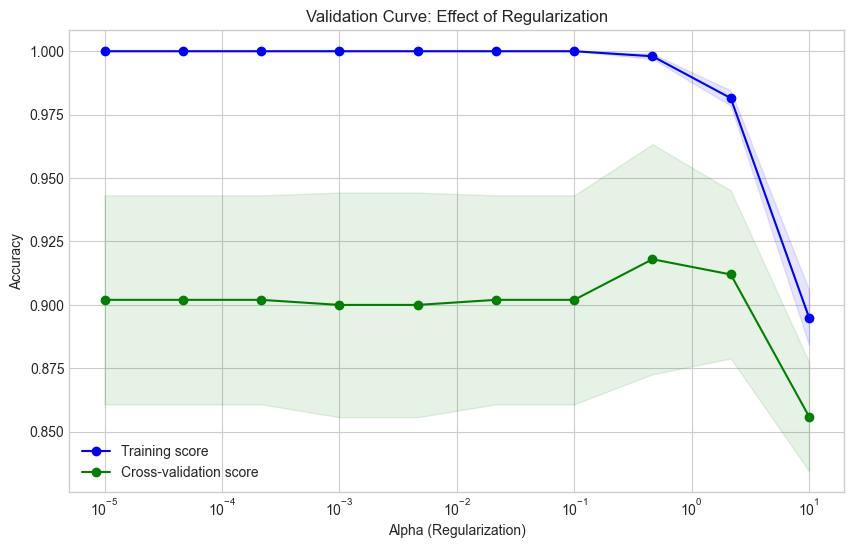

Optimal alpha: 0.464159


In [17]:
# Validation curve for alpha (regularization)
param_range = np.logspace(-5, 1, 10)

train_scores, test_scores = validation_curve(
    MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42),
    X_scaled, y,
    param_name='alpha',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate mean and std
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plot
plt.figure(figsize=(10, 6))

plt.semilogx(param_range, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.semilogx(param_range, test_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.xlabel('Alpha (Regularization)')
plt.ylabel('Accuracy')
plt.title('Validation Curve: Effect of Regularization')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Find optimal alpha
optimal_alpha = param_range[np.argmax(test_mean)]
print(f"Optimal alpha: {optimal_alpha:.6f}")

**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

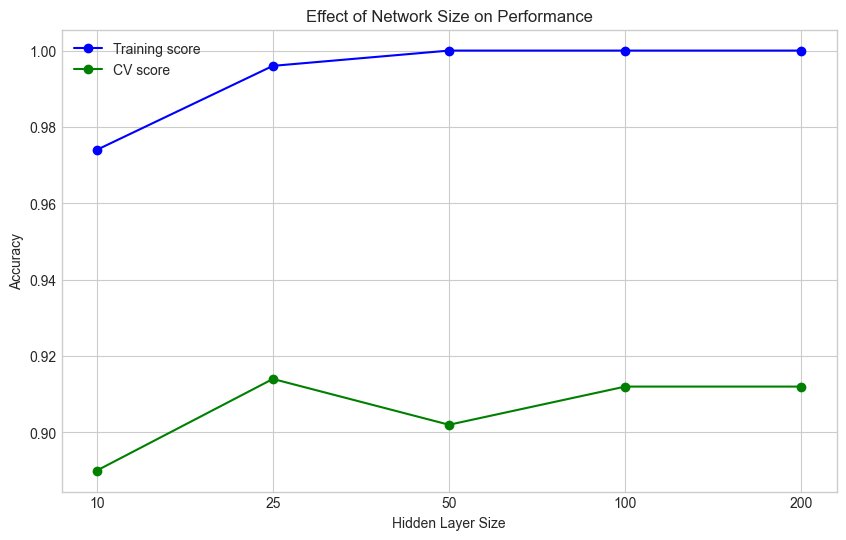

In [18]:
# Validation curve for hidden layer size
hidden_sizes = [(10,), (25,), (50,), (100,), (200,)]

train_scores_list = []
test_scores_list = []

for size in hidden_sizes:
    clf = MLPClassifier(hidden_layer_sizes=size, max_iter=500, random_state=42)
    scores = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
    
    # Also get training scores
    clf.fit(X_scaled, y)
    train_acc = clf.score(X_scaled, y)
    
    train_scores_list.append(train_acc)
    test_scores_list.append(scores.mean())

# Plot
plt.figure(figsize=(10, 6))

x_labels = [str(s[0]) for s in hidden_sizes]
x_pos = np.arange(len(hidden_sizes))

plt.plot(x_pos, train_scores_list, 'o-', color='blue', label='Training score')
plt.plot(x_pos, test_scores_list, 'o-', color='green', label='CV score')

plt.xticks(x_pos, x_labels)
plt.xlabel('Hidden Layer Size')
plt.ylabel('Accuracy')
plt.title('Effect of Network Size on Performance')
plt.legend()
plt.grid(True)
plt.show()

## Part 8: Comparing Models

In [19]:
# ============================================================
# [コードの説明]
# ============================================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
}

# Compare with cross-validation
results = {}
print("Model Comparison (5-Fold CV):")
print("="*60)

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    results[name] = scores
    print(f"{name:25s}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

Model Comparison (5-Fold CV):
Logistic Regression      : 0.8060 (+/- 0.0601)
Decision Tree            : 0.7960 (+/- 0.1163)
Random Forest            : 0.8820 (+/- 0.0625)
SVM                      : 0.9160 (+/- 0.0614)


/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP                      : 0.9020 (+/- 0.0824)


/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

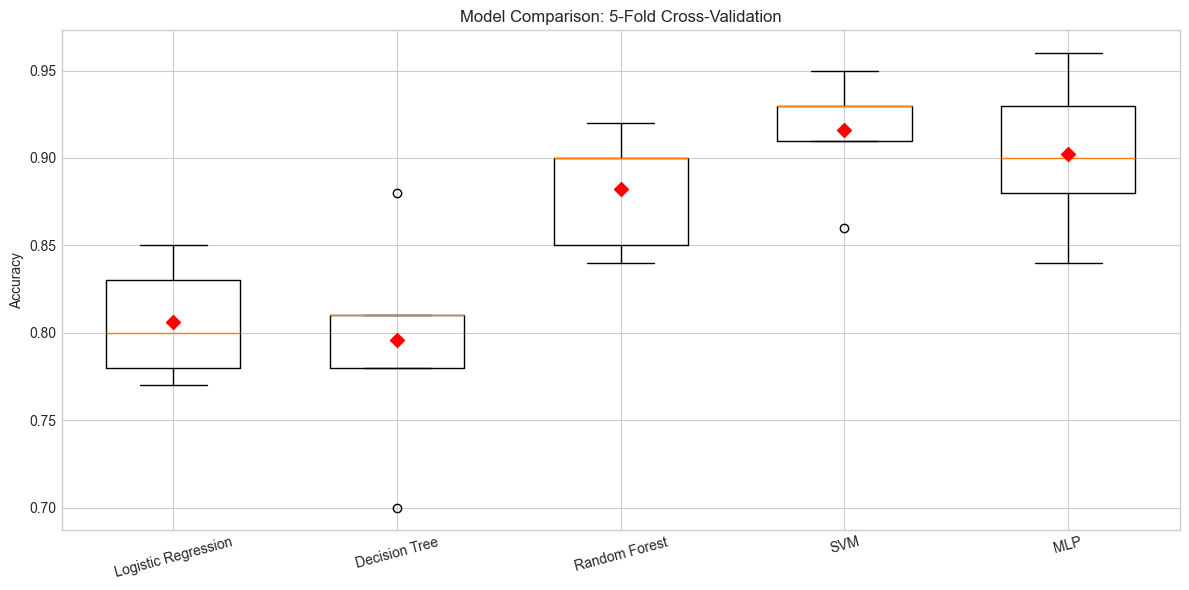

In [20]:
# ============================================================
# [コードの説明]
# ============================================================

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

names = list(results.keys())
positions = np.arange(len(names))

bp = ax.boxplot([results[name] for name in names], positions=positions, widths=0.6)

ax.set_xticks(positions)
ax.set_xticklabels(names, rotation=15)
ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison: 5-Fold Cross-Validation')

# Add mean markers
means = [results[name].mean() for name in names]
ax.scatter(positions, means, marker='D', color='red', s=50, zorder=3)

plt.tight_layout()
plt.show()

## Summary

In this notebook, you learned:

### Regression Metrics
- **MSE/RMSE**: Penalize large errors
- **MAE**: Average absolute error
- **R²**: Variance explained

### Classification Metrics
- **Accuracy**: Overall correctness
- **Precision**: True positives / predicted positives
- **Recall**: True positives / actual positives
- **F1**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under ROC curve

### Model Evaluation Tools
- **Confusion Matrix**: Detailed error analysis
- **Cross-Validation**: Robust performance estimation
- **Learning Curves**: Diagnose overfitting/underfitting
- **Validation Curves**: Tune hyperparameters

### Key Takeaways
- Choose metrics based on your problem requirements
- Use cross-validation for robust estimates
- Learning curves help diagnose model issues
- Always consider class imbalance when choosing metrics

### Next Steps
Continue to **Notebook 04** to learn about linear models with parameter simulation.

---

## ➡️ 次のステップ

### 学習を続ける

**📗 Notebook 04: Linear Models**

### 復習が必要な場合

- **Notebook 02: 前処理**
- **Notebook 03: 評価指標**

### さらに学ぶために

**書籍:**
- "Hands-On Machine Learning" by Aurélien Géron
- "Pattern Recognition and Machine Learning" by Christopher Bishop

**オンラインリソース:**
- scikit-learn documentation: https://scikit-learn.org
- Kaggle: 実データで練習
- UCI ML Repository: データセット

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！
